## Question Answering System using End to End Memory Networks

## Imports

In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Permute, dot, add, concatenate
from keras.layers import LSTM, Dense, Dropout, Input, Activation
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


### Helper functions

In [2]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


In [3]:
def parse_stories(lines):
    '''Parse stories provided in the bAbi tasks format
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            # Provide all the substories
            substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


In [4]:
def get_stories(f):
    data = parse_stories(f.readlines())
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data]
    return data

In [5]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))


In [6]:
class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()

## Downloading the dataset

In [7]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise
tar = tarfile.open(path)

## Getting train and test stories

In [8]:
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'

print('Extracting stories for the challenge: single_supporting_fact_10k')
train_stories = get_stories(tar.extractfile(challenge.format('train')))
test_stories = get_stories(tar.extractfile(challenge.format('test')))

Extracting stories for the challenge: single_supporting_fact_10k


/home/abhijeet/anaconda3/envs/tensorflow/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [9]:
len(train_stories), len(test_stories)

(10000, 1000)

In [10]:
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
train_stories[0]

Number of training stories: 10000
Number of test stories: 1000


(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.'],
 ['Where', 'is', 'Mary', '?'],
 'bathroom')

## Preprocessing the data

In [11]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))


word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)

In [12]:
print('-------------------------')
print('Vocabulary:\n',vocab,"\n")
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-------------------------')

-------------------------
Vocabulary:
 ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'back', 'bathroom', 'bedroom', 'garden', 'hallway', 'is', 'journeyed', 'kitchen', 'moved', 'office', 'the', 'to', 'travelled', 'went'] 

Vocab size: 22 unique words
Story max length: 68 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-------------------------


In [13]:
print('-------------------------')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('input train sample', inputs_train[0,:])
print('-------------------------')

-------------------------
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 68)
inputs_test shape: (1000, 68)
input train sample [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  5 16 19 18  9  1  4 21 19 18 12  1]
-------------------------


In [14]:
print('-------------------------') 
print('queries: integer tensor of shape (samples, max_length)') 
print('queries_train shape:', queries_train.shape) 
print('queries_test shape:', queries_test.shape) 
print('query train sample', queries_train[0,:]) 
print('-------------------------')

-------------------------
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
query train sample [ 7 13  5  2]
-------------------------


In [15]:
print('-------------------------') 
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)') 
print('answers_train shape:', answers_train.shape) 
print('answers_test shape:', answers_test.shape) 
print('answer train sample', answers_train[0,:]) 
print('-------------------------')

-------------------------
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 22)
answers_test shape: (1000, 22)
answer train sample [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------


In [16]:
train_epochs = 100
batch_size = 32
lstm_size = 64
embed_size = 50
dropout_rate = 0.3

## Building the model

In [17]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=query_maxlen))
question_encoder.add(Dropout(dropout_rate))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)


# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
print(match.shape)
match = Activation('softmax')(match)
print('Match shape', match.shape)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)
print('Response shape', response)

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Input sequence: Tensor("input_1:0", shape=(?, 68), dtype=float32)
Question: Tensor("input_2:0", shape=(?, 4), dtype=float32)
Input encoded m Tensor("sequential_1/dropout_1/cond/Merge:0", shape=(?, 68, 50), dtype=float32)
Input encoded c Tensor("sequential_2/dropout_2/cond/Merge:0", shape=(?, 68, 4), dtype=float32)
Question encoded Tensor("sequential_3/dropout_3/cond/Merge:0", shape=(?, 4, 50), dtype=float32)
(?, 68, 4)
Match shape (?, 68, 4)
Response shape Tensor("permute_1/transpose:0", shape=(?, 4, 68), dtype=float32)
Answer shape Tensor("concatenate_1/concat:0", shape=(?, 4, 118), dtype=float32)


In [18]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

## Model summary

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 68)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             1100        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4, 50)        1100        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

## Training the model and using Keras Callbacks for Visualization

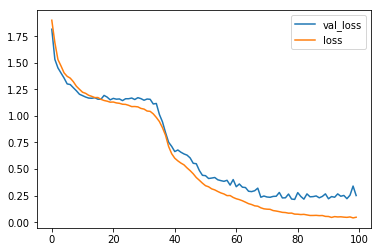

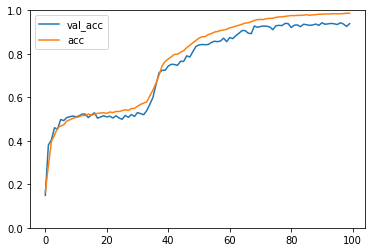

In [20]:
model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs, callbacks=[TrainingVisualizer()],
          validation_data=([inputs_test, queries_test], answers_test))

model.save('model.h5')

## Test Result Analysis

In [21]:
for i in range(0,10):
        current_inp = test_stories[i]
        current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
        current_prediction = model.predict([current_story, current_query])
        current_prediction = idx_word[np.argmax(current_prediction)]
        print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
        print("-----------------------------------------------------------------------------------------")


John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: hallway | Ground Truth: hallway
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . Where is Mary ? | Prediction: bathroom | Ground Truth: bathroom
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Where is Sandra ? | Prediction: kitchen | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . San

## Custom Inputs for demo

In [22]:
# print('-------------------------------------------------------------------------------------------')
# print('Custom User Queries (Make sure there are spaces before each word)')
# while 1:
#     print('-------------------------------------------------------------------------------------------')
#     print('Please input a story')
#     user_story_inp = input().split(' ')
#     print('Please input a query')
#     user_query_inp = input().split(' ')
#     user_story, user_query, user_ans = vectorize_stories([[user_story_inp, user_query_inp, '.']], word_idx, story_maxlen, query_maxlen)
#     user_prediction = model.predict([user_story, user_query])
#     user_prediction = idx_word[np.argmax(user_prediction)]
#     print('Result')
#     print(' '.join(user_story_inp), ' '.join(user_query_inp), '| Prediction:', user_prediction)

In [23]:
# Mary went to the bathroom . John moved to the hallway . Mary travelled to the office . # Where is Mary ?
# Sandra travelled to the office . John journeyed to the garden .